#### 3

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_rus_summed.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000
var_freq  <- 12    
var_start_year  <- 2006      
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 24
var_window  <-  84 - 1
var_topup  <-  -1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(11,0,0)
var_sarpdq   <-  c(2,0,0)
var_drift   <-  FALSE
var_constant   <-  TRUE

var_char  <-  c(4,2)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
var_countries  <-  dim(read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 ))[2]+1
this_file_models_list  <-  list()
this_model_list  <-  list()



In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  

    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }


    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(rep(0, var_countries), rep(1, (ncol(allts)-var_countries) )))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)     
    }


[1]   1  84  85 108
          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120
[1]  25 108 109 132
|[1]  37 120 121 144
|[1]  49 132 133 156


In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -14594.1333 -16054.2938 -15144.5238  -3559.5976  -6264.0279   8264.6500
 [7]  13192.2495  -7100.5298  -2495.2161  -7953.8590 -17810.2114 -29199.4849
[13] -18387.1404 -21645.4968 -14132.0125 -14442.3342 -16662.5146   -410.4306
[19]  -3463.2786 -18507.1062 -12196.1528 -24986.2123 -29335.8185 -36602.6041

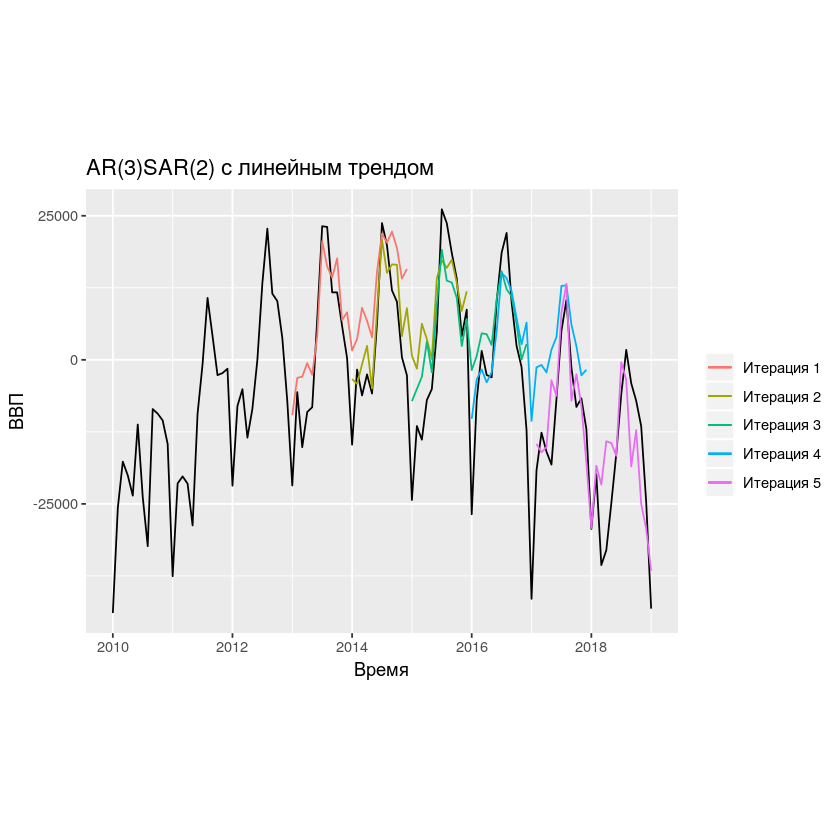

In [13]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [14]:
this_file_models_list[[1]]  <-  this_model_list


In [15]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-4658.5948  9404.5364   155.0565    25.2000

In [16]:
df_mean_acc <- readRDS("df_mean_acc_noweights.rds")

df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,10496.554
2 level (state),102.22984,263.5522,10507.589
2 level (type),92.26188,237.9379,9970.511
2 level (clusetered),97.38575,216.4971,10387.388


In [17]:
df_mean_acc[2,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,9404.536
2 level (state),102.22984,263.5522,10507.589
2 level (type),92.26188,237.9379,9970.511
2 level (clusetered),97.38575,216.4971,10387.388


In [18]:
df_acc

ME,RMSE,MAPE,Iteration
-6728.390,9328.547,370.46501,1
-4589.234,9045.621,123.59267,13
-3349.038,8901.844,83.28669,25
-7373.608,11654.777,117.55723,37
-1252.705,8091.893,80.38090,50


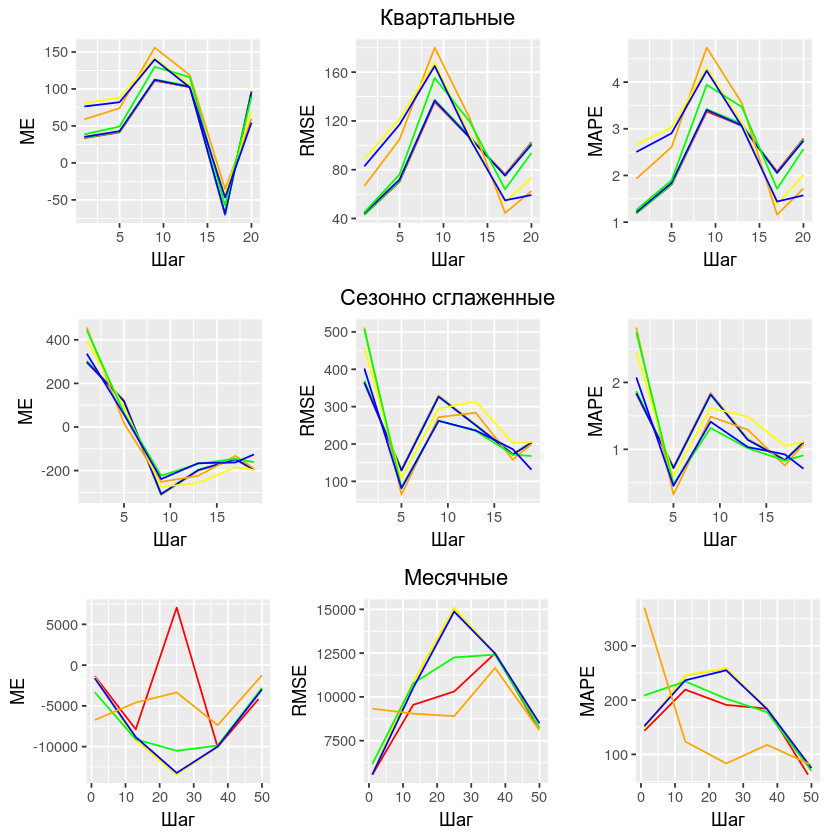

In [19]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all_noweights.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [20]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_state.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [21]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [22]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [23]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  

    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }



[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


In [24]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [25]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [26]:

this_file_models_list[[2]]  <-  this_model_list


In [27]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -17362.0822 -12993.7680 -11126.6079  -6131.3779    803.7356  12406.8058
 [7]  12604.5040    660.8058  -4720.6207 -10224.2146 -15513.1207 -34385.6331
[13] -21359.9023 -17278.3119 -15191.4090 -14386.7357  -8388.2302  -2017.3310
[19]  -2724.1410 -12167.5283 -16903.1739 -22544.5201 -27208.2879 -42937.3328

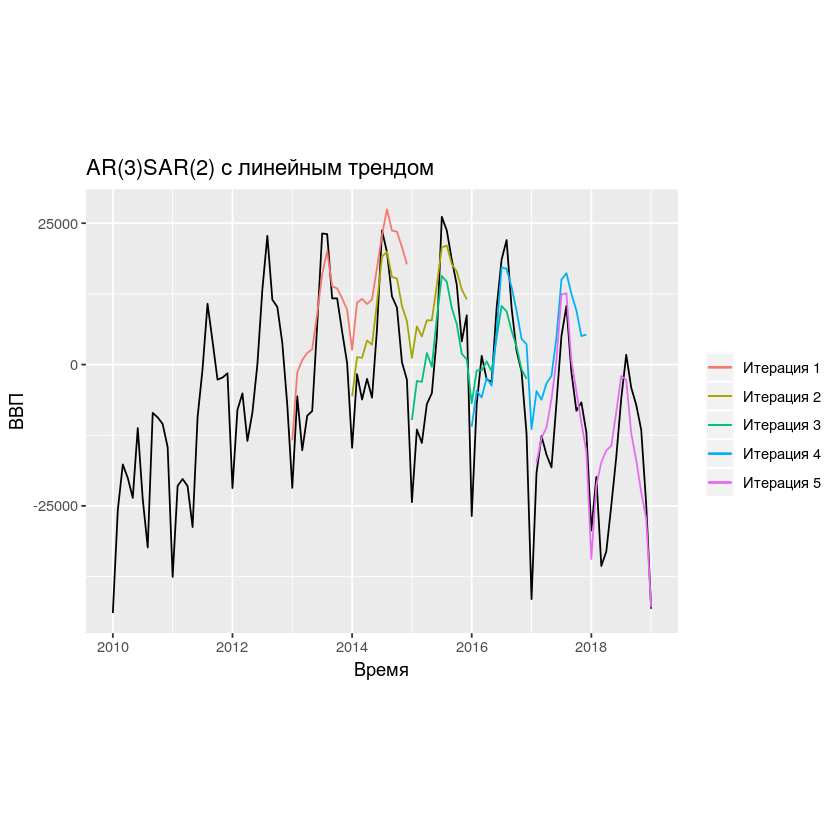

In [28]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [29]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-5485.8026 10101.7056   202.9555    25.2000

In [30]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [31]:
df_mean_acc[3,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,9404.536
2 level (state),102.22984,263.5522,10101.706
2 level (type),92.26188,237.9379,9970.511
2 level (clusetered),97.38575,216.4971,10387.388


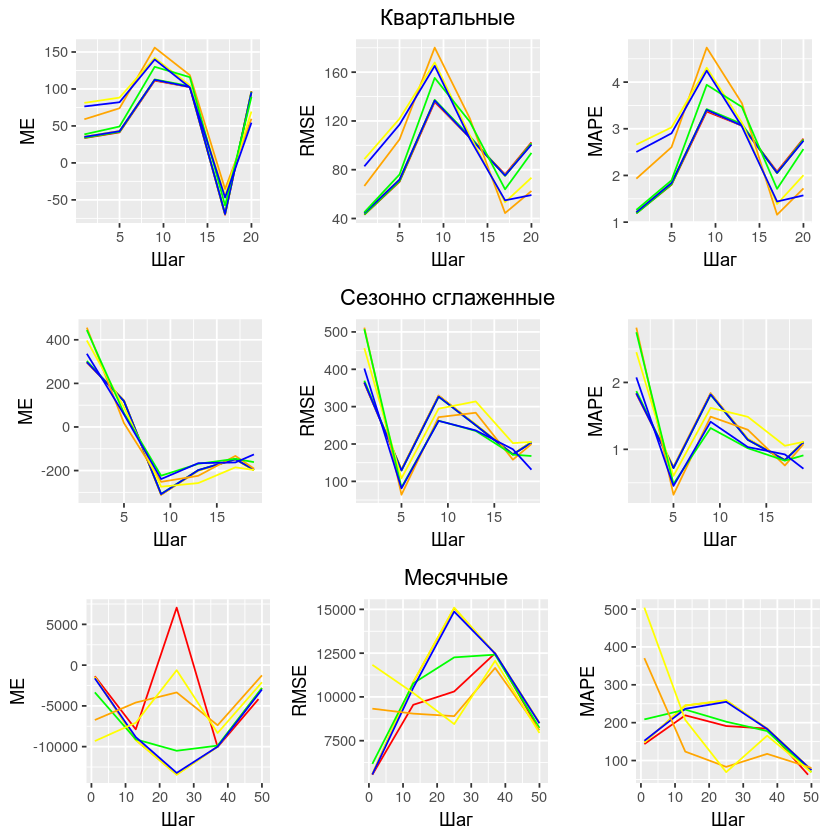

In [32]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [33]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_type.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [34]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [35]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [36]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  

    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }




[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


In [37]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [38]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [39]:
this_file_models_list[[3]]  <-  this_model_list


In [40]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -16222.5442 -15241.4180 -12338.7219  -2575.5278  -2852.5286  10003.8615
 [7]  15645.2349  -1433.3297   1360.5814  -3276.3123 -18410.6706 -36251.1967
[13] -21389.1554 -24438.3823 -14168.7119 -13677.0587 -13724.5763   3846.5630
[19]    934.5829 -14585.9566  -6001.5350 -19658.6676 -29131.9141 -40498.4361

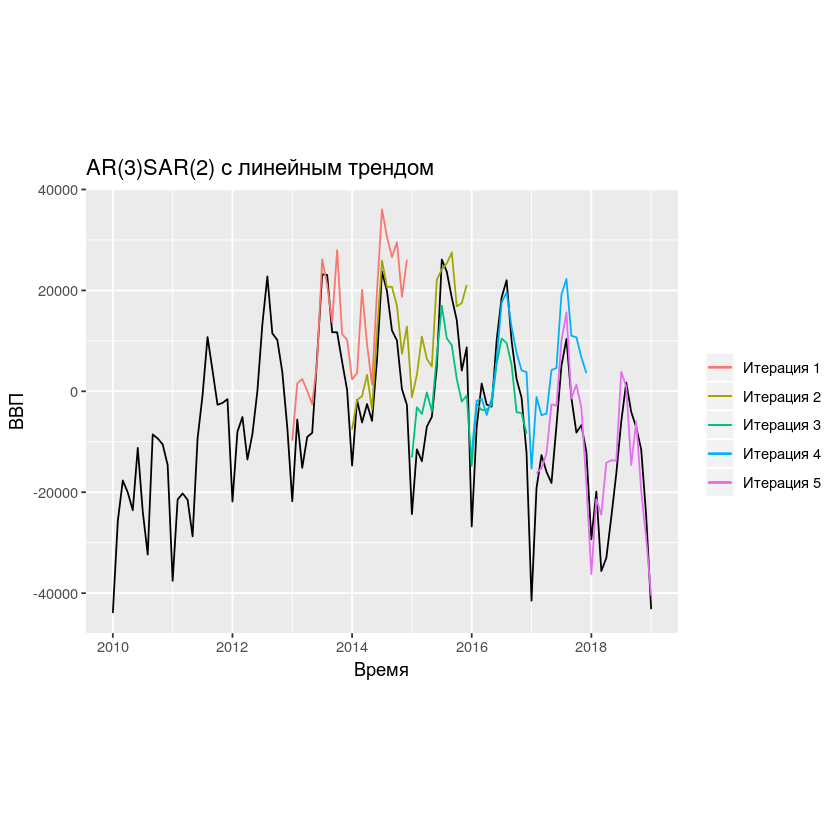

In [41]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [42]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-6003.8748 10540.5059   196.3778    25.2000

In [43]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [44]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,9404.536
2 level (state),102.22984,263.5522,10101.706
2 level (type),92.26188,237.9379,9970.511
2 level (clusetered),97.38575,216.4971,10387.388


In [45]:
df_mean_acc[4,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,9404.536
2 level (state),102.22984,263.5522,10101.706
2 level (type),92.26188,237.9379,10540.506
2 level (clusetered),97.38575,216.4971,10387.388


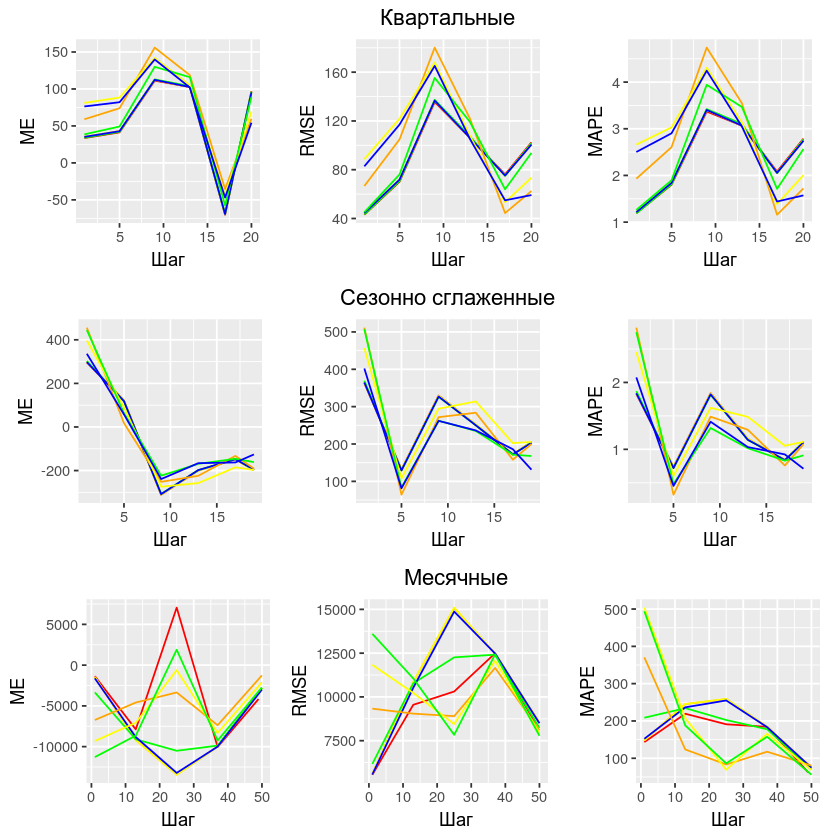

In [46]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [47]:
df_eu  <-  read.csv(file="../clustering/hts_rus_summed_clust.csv", header=TRUE, sep=",", row.names =1 )
# df_eu  <-  df_eu/1000


In [48]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [49]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [50]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    t <- train_start:train_end
    regressors <- cbind(trend=t,quad=t^2)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="ML"), 
            error = function(e) 
                              {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, xreg = regressors, method="CSS"),
                         error = function(e)              
                            auto.arima(msts(allts[,j], seasonal.periods = var_freq))
                         )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    t_f <- test_start:test_end
    regressors_f <- cbind(trend=t_f,quad=t_f^2) 
    
    
    
    for(j in 1:ncol(allts)){  

    allf[,j] <- tryCatch(        
    { forecast(ms[[j]], h=var_h, xreg = regressors_f)$mean}, 
            error = function(e) 
                tryCatch(        
    { forecast(ms[[j]], h=var_h)$mean}, 
            error = function(e) 
        {rwf(allts[,j],h=var_h)$mean}
    
            )    
            )

    
    }

        allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g, weights = c(0,rep(1, dim(df_eu)[2])))
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
    gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
    this_model_list[[k]]  <- ms
    l[[k]]  <- allts(gts_forecasts_7)
    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 
    progress(i, progress.bar = TRUE)
    }



[1]   1  84  85 108


Since argument characters are not specified, the default labelling system is used.


          0%---------25%---------50%---------75%--------100%
Progress: [1]  13  96  97 120


Since argument characters are not specified, the default labelling system is used.


[1]  25 108 109 132


Since argument characters are not specified, the default labelling system is used.


|[1]  37 120 121 144


Since argument characters are not specified, the default labelling system is used.


|[1]  49 132 133 156


Since argument characters are not specified, the default labelling system is used.


In [51]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [52]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [53]:
this_file_models_list[[4]]  <-  this_model_list


In [54]:
l[[5]][,1]

Time Series:
Start = 85 
End = 108 
Frequency = 1 
 [1] -15455.2030 -15121.4582 -12387.7640    373.7376  -2001.4854  13359.4512
 [7]  20171.7409    218.8757   7693.5563   2284.1423 -13025.6498 -28372.6850
[13] -16527.3379 -20193.5942  -9707.2657  -9055.2430 -11517.9836   8126.2453
[19]   3671.8955 -12647.4177    935.0664 -13363.4665 -19923.4177 -28095.3056

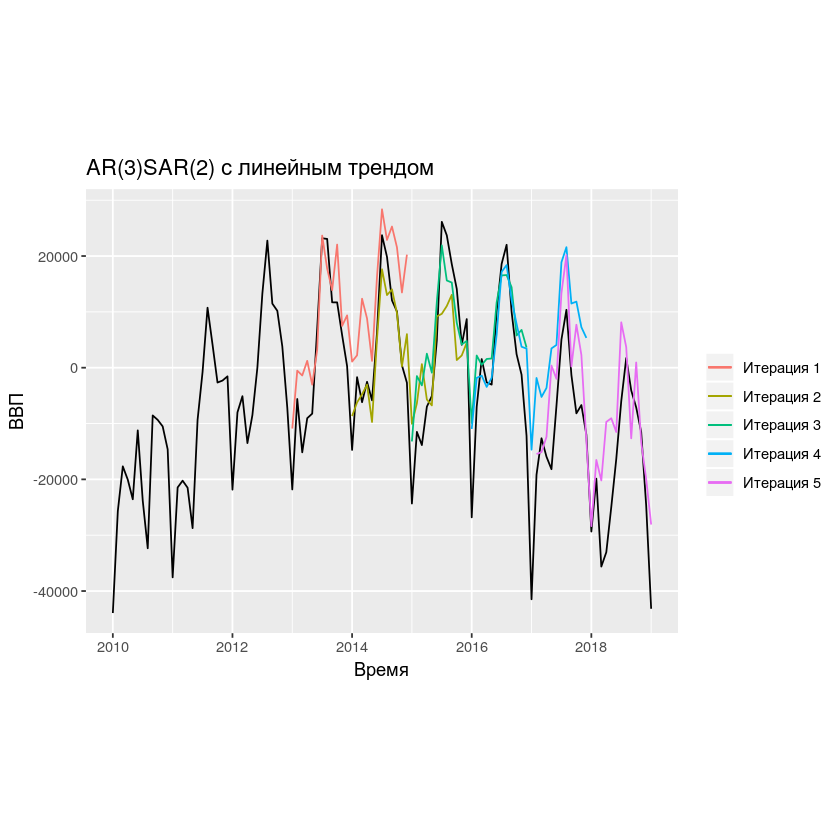

In [55]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [56]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
-5436.5971  9726.5157   158.9436    25.2000

In [57]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [58]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,9404.536
2 level (state),102.22984,263.5522,10101.706
2 level (type),92.26188,237.9379,10540.506
2 level (clusetered),97.38575,216.4971,10387.388


In [59]:
df_mean_acc[5,3]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,9404.536
2 level (state),102.22984,263.5522,10101.706
2 level (type),92.26188,237.9379,10540.506
2 level (clusetered),97.38575,216.4971,9726.516


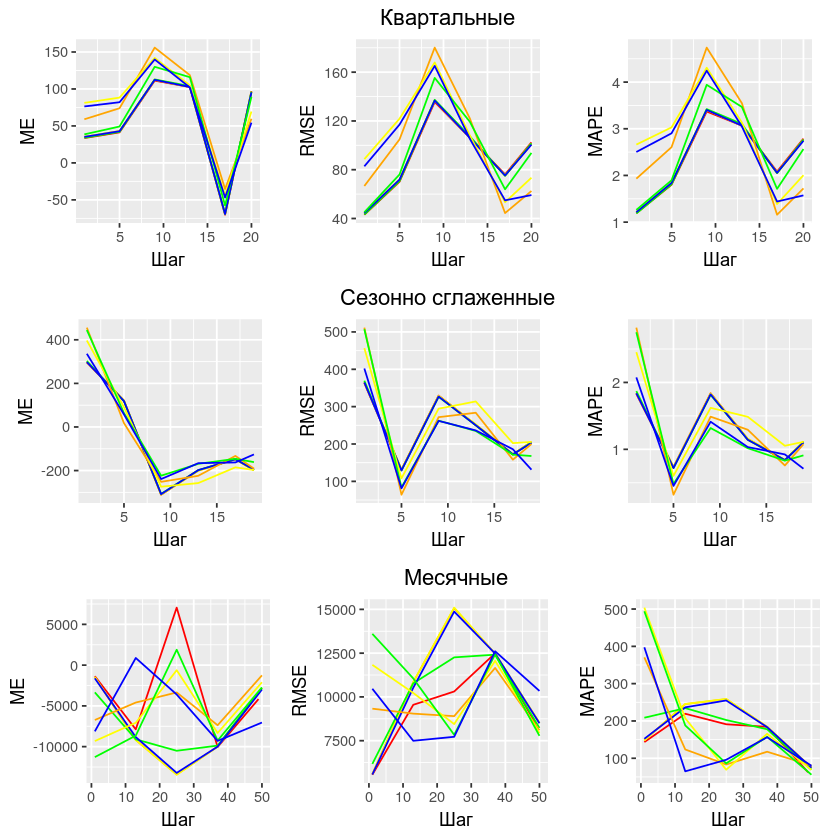

In [60]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 6
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [61]:
saveRDS(df_mean_acc, "df_mean_acc_noweights.rds")
saveRDS(plots_test_all, "plots_test_not_all_noweights.rds")



In [62]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,88.92257,242.1291,9146.793
3 level,96.77646,248.2335,9404.536
2 level (state),102.22984,263.5522,10101.706
2 level (type),92.26188,237.9379,10540.506
2 level (clusetered),97.38575,216.4971,9726.516


In [63]:
all_models_list <- readRDS("all_models_list.rds")
all_models_list[[3]]  <-  this_file_models_list
saveRDS(all_models_list, "all_models_list.rds")

